In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os
import requests
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from scipy import ndimage
from keras.layers import Input, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix,classification_report


## Objective
The main goal of this project is to create a machine learning model that will classify waste. As the global population continues to grow, waste production is increasing at an alarming rate. Mismanaged waste damages ecosystems, pollutes the environment, and presents health implications to both wildlife and humans. Conventional waste classificaiton methods are time0consuming, labor-intesive, and predominantly error-prone. The machine learning model will address such challenges and offer a solution to waste-management.   

## Setting up Training and Testing Directories
The dataset originates from Kaggle: https://www.kaggle.com/datasets/techsash/waste-classification-data
  

In [111]:
#Setting up paths for directories 
dir_base='DATASET'
dir_train=os.path.join(dir_base, 'TRAIN')
dir_test=os.path.join(dir_base, 'TEST')

#Training Organic 
dir_train_o=os.path.join(dir_train, 'O')

#Training recycling 
dir_train_r=os.path.join(dir_train, 'R')

#Testing Organic
dir_test_o=os.path.join(dir_test, 'O')

#Testing Recycling
dir_test_r=os.path.join(dir_test, 'R')

print('Total Number of Training Organic Images:', len(os.listdir(dir_train_o)))
print('Total Number of Training Recycling Images:', len(os.listdir(dir_train_r)))
print('Total Number of Testing Organic Images:', len(os.listdir(dir_test_o)))
print('Total Number of Testing Recycling Images:', len(os.listdir(dir_test_r)))


Total Number of Training Organic Images: 12565
Total Number of Training Recycling Images: 9999
Total Number of Testing Organic Images: 1401
Total Number of Testing Recycling Images: 1112


## Exploring the Shape of the Images

(160, 315, 3)
(174, 290, 3)
(203, 248, 3)
(183, 275, 3)
(183, 276, 3)
(240, 210, 3)
(194, 259, 3)
(195, 258, 3)


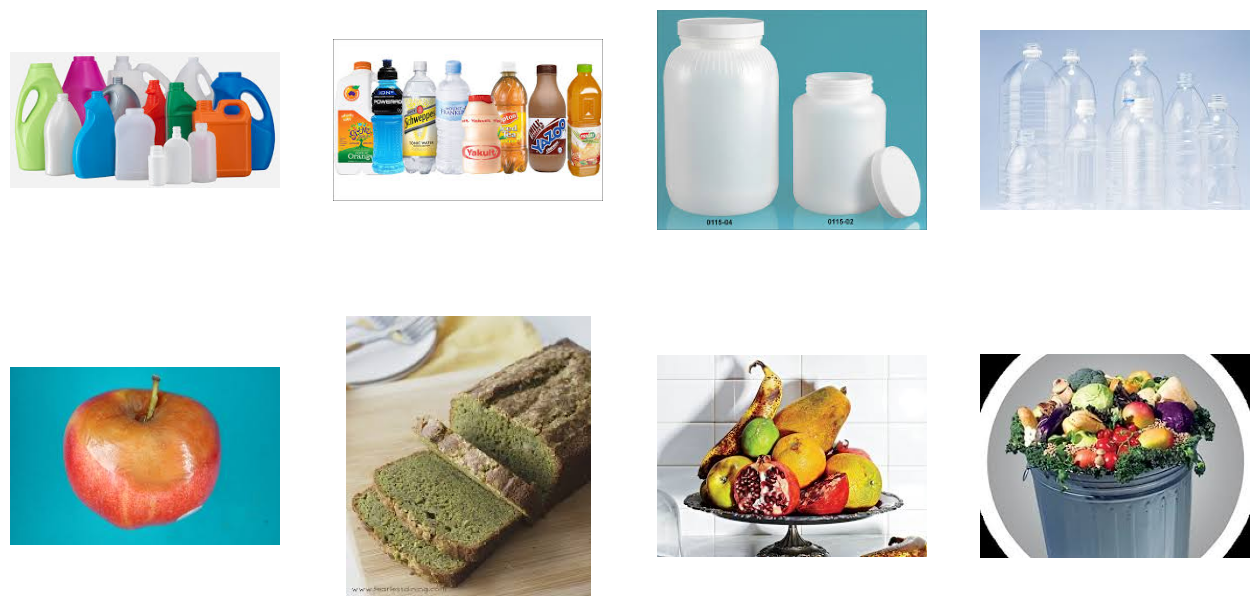

In [112]:
file_names_train_o=os.listdir(dir_train_o)
file_names_train_r=os.listdir(dir_train_r)

#sorting in alphabetical order
file_names_train_r.sort()

#used to display matplot inline with notebook interface 
%matplotlib inline

#parameters for our graph: we will output images in a 2x4 configurations
num_cols=4
num_rows=2 

#index for iterating over our images 
image_index=4

#creating a matplotlib figure object that will fit 2x4 image
figure=plt.gcf()
figure.set_size_inches(num_cols*4, num_rows*4)

image_index=image_index+4

#our next organic image 
next_o_image=[os.path.join(dir_train_o, fname) for fname in file_names_train_o[image_index-4:image_index]]

#our next recycle image 
next_r_image=[os.path.join(dir_train_r, fname) for fname in file_names_train_r[image_index-4: image_index]]

#the loop iterates through combined list of image path, and with each iteration, it assignes the index of the current element to 'i' and the value of the current element to 'image_path'
for i, image_path in enumerate(next_r_image+next_o_image):
    #creating the subplot 
    subplot=plt.subplot(num_rows, num_cols, i+1)
    #reading the image using the image_path 
    image=mpimg.imread(image_path)
    #displays the image on the subplot 
    plt.imshow(image)
    subplot.axis('Off')
    print(image.shape)
    

#used to dispaly the entire grid of images within the matplotlib 
plt.show()








## Data Pre-processing 

In [113]:
# Create instances of ImageDataGenerator for data augmentation and normalization
train_data_augmentation = ImageDataGenerator(rescale=1./255)
test_data_augmentation = ImageDataGenerator(rescale=1./255)

# Prepare data generators for training and testing
def prepare_data_generators(train_dir, test_dir):
    """
    Prepare data generators for training and testing.

    Parameters:
    - train_dir: Path to the directory containing training images
    - test_dir: Path to the directory containing test images
    
    Returns:
    - generator_train: Data generator for training images
    - generator_test: Data generator for test images
    """
    # Flow training images in batches of 20 using train_data_augmentation
    generator_train = train_data_augmentation.flow_from_directory(train_dir, target_size=(150, 150), shuffle=True, class_mode='binary')

    # Flow test images in batches of 20 using test_data_augmentation
    generator_test = test_data_augmentation.flow_from_directory(test_dir, target_size=(150, 150), shuffle=True, class_mode='binary')
    
    return generator_train, generator_test

# Get data generators
generator_train, generator_test = prepare_data_generators(dir_train, dir_test)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


## Models:
- CNN Architecture from scratch 
- Pre-trained CNN Architecture:
     - Inception Network
     - ResNet-50 Network 


  

### CNN Architecture

In [114]:
input_image=layers.Input(shape=(150, 150, 3))

#First convlusion extracts 16 filters that are 3x3 
#Convolution is followed by max-pooling layer with 2x2 window 
x=layers.Conv2D(32,(3, 3), activation='relu', padding='same')(input_image)
x=layers.MaxPooling2D(2)(x)

#the second convlultion will extract 32 filters that are 3x3
#convultion is followed by max-pooling layer with a 2x2 window 
x=layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x=layers.MaxPooling2D(2)(x)

#Third Convultion extracts 64 filters that are 3x3 
x=layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x=layers.MaxPooling2D(2)(x)

#flatten feature map to a 1-dimension tensor so that we can add fully connect layers 
x=layers.Flatten()(x)

#creating a fully connected layer with relu activation and 512 hidden units 
#has a drop out rate of 0.5->helps over-fitting by randomly setting a fraction of the input units to 0 during training to prevent the network from being too dependent on any single feature 
x=layers.Dense(512, activation='relu')(x)
x=layers.Dropout(0.5)(x)

#creating an output layer with a single node and sigmoid activation 
#singmoid activation is generally used in binaryt classification tasks to produce a probability-like output 
output_layer=layers.Dense(1, activation='sigmoid')(x)

#Create the Model using Keras Model Class 
waste_model=Model(inputs=input_image, outputs=output_layer)


#### Model Summary 

In [115]:
waste_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_200 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_201 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 37, 37, 128)       7385

#### Training the Model


In [116]:
waste_model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

model_history=waste_model.fit(generator_train, epochs=8, validation_data=generator_test, verbose=2, shuffle=True)

Epoch 1/8
706/706 - 227s - loss: 0.4831 - acc: 0.8007 - val_loss: 0.6653 - val_acc: 0.7784 - 227s/epoch - 321ms/step
Epoch 2/8
706/706 - 220s - loss: 0.3851 - acc: 0.8413 - val_loss: 0.5427 - val_acc: 0.8436 - 220s/epoch - 312ms/step
Epoch 3/8
706/706 - 223s - loss: 0.3670 - acc: 0.8517 - val_loss: 0.2987 - val_acc: 0.8938 - 223s/epoch - 316ms/step
Epoch 4/8
706/706 - 215s - loss: 0.3540 - acc: 0.8593 - val_loss: 0.3527 - val_acc: 0.8790 - 215s/epoch - 305ms/step
Epoch 5/8
706/706 - 217s - loss: 0.3566 - acc: 0.8605 - val_loss: 0.2878 - val_acc: 0.8953 - 217s/epoch - 307ms/step
Epoch 6/8
706/706 - 212s - loss: 0.3557 - acc: 0.8587 - val_loss: 0.3029 - val_acc: 0.8989 - 212s/epoch - 301ms/step
Epoch 7/8
706/706 - 209s - loss: 0.3540 - acc: 0.8620 - val_loss: 0.3098 - val_acc: 0.8957 - 209s/epoch - 296ms/step
Epoch 8/8
706/706 - 209s - loss: 0.3611 - acc: 0.8571 - val_loss: 0.3279 - val_acc: 0.8687 - 209s/epoch - 297ms/step


#### Training and Testing Accuracy/Loss Visualizations

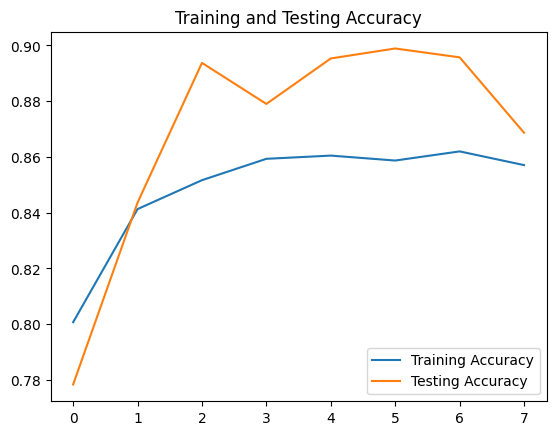

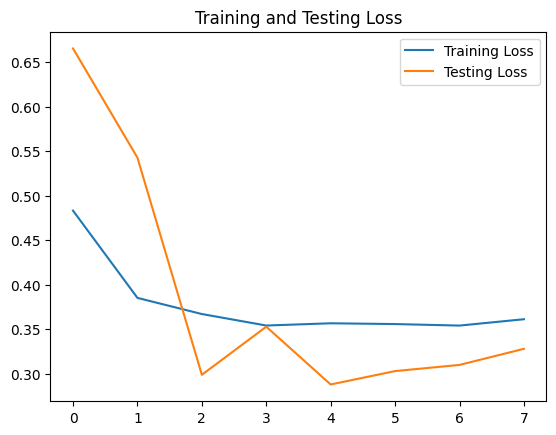

In [117]:
accuracy=model_history.history['acc']
test_accuracy=model_history.history['val_acc']

#getting the loss for each training epoch 
loss=model_history.history['loss']
loss_test=model_history.history['val_loss']

#number of training iterations 
num_epochs=range(len(accuracy))

#plotting testing and training accuracy per epoch 
plt.plot(num_epochs, accuracy, label='Training Accuracy')
plt.plot(num_epochs, test_accuracy, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

#plotting testing and training loss per epoch 
plt.figure()
plt.plot(num_epochs, loss, label='Training Loss')
plt.plot(num_epochs, loss_test, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()

#### Results

In [118]:
#Flow validation images using test_data_augmentation generator 
test_visual=test_data_augmentation.flow_from_directory(dir_test, target_size=(150, 150), class_mode='binary', shuffle=True)
print(test_visual.class_indices) 

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [119]:
test_prediction=waste_model.predict(test_visual)

79/79 [==============================] - 7s 81ms/step


In [120]:
dir_test_indices=test_visual.index_array
test_correct_labels = [0 if n < 1112 else 1 for n in dir_test_indices]
# getting predictions in the form of probablities 
test_predictions_prob = waste_model.predict(test_visual)

# converting the probablities into binary values 
test_prediction_labels = [1 if n >= 0.5 else 0 for n in test_predictions_prob]

print("CNN Waste Model Predictions: "+str(test_prediction_labels))
print("CNN Correct Labels:"+str(test_correct_labels))

# determining the filepaths of misclassified waste
misclasssified_num = 0
misclassified_filepaths = []
correct = []
for predicted_label, correct_label, dir_index in zip(test_prediction_labels, test_correct_labels, test_visual.index_array):
  misclassified_filepaths.append(test_visual.filepaths[dir_index])
  if predicted_label != correct_label:
    correct.append('incorrect')
    misclasssified_num+= 1
  else:
    correct.append('correct')

print("# of Total Images: "+str(len(correct)))
print("# of Misclassified Images: "+str(misclasssified_num))
     

79/79 [==============================] - 6s 76ms/step
CNN Waste Model Predictions: [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1

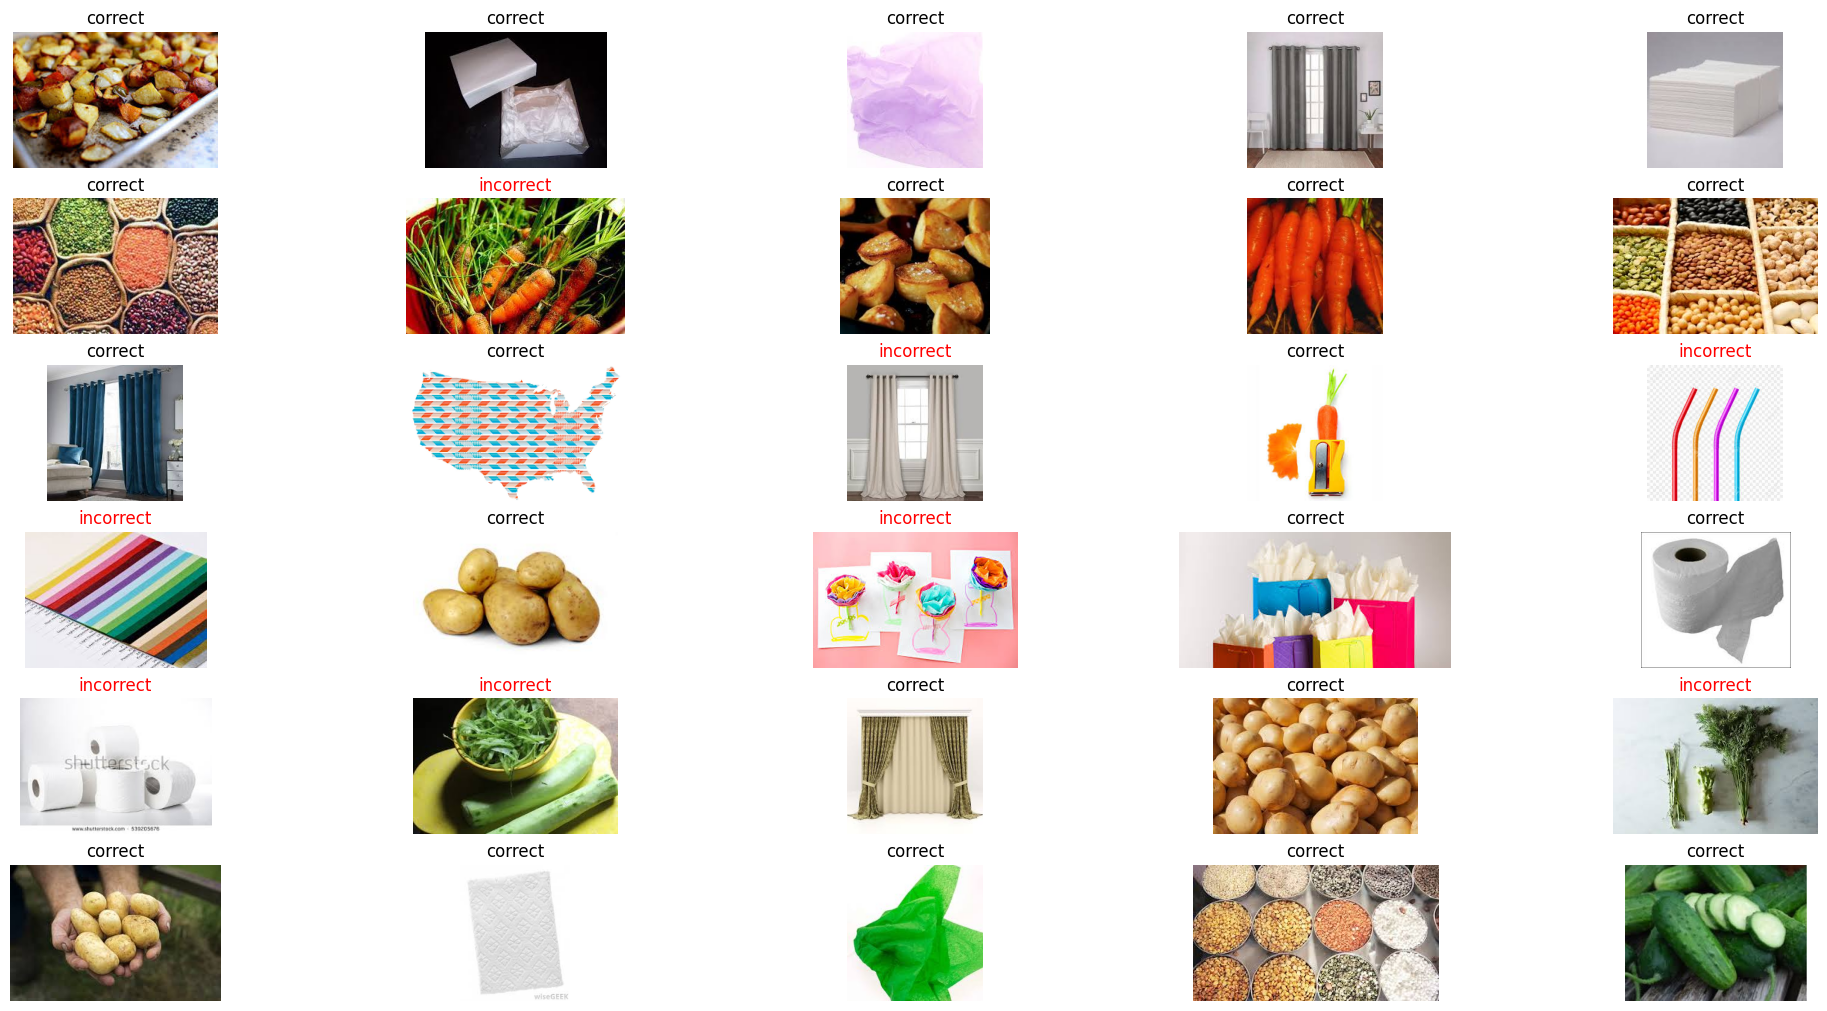

In [121]:
misclassified_images = []
for filepath in misclassified_filepaths:
  misclassified_images.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for x in range(6):
  for y in range(5):
    axarr[x,y].imshow(misclassified_images[count])
    if correct[count] == 'correct':
      axarr[x,y].set_title(correct[count])
    else:
      axarr[x,y].set_title(correct[count], color='red')
    axarr[x,y].set_axis_off()
    count += 1 
plt.show()

In [122]:
# confusion matrix
matrix = confusion_matrix(test_correct_labels, test_prediction_labels, labels=[0, 1])
print('Confusion Matrix: \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(test_correct_labels, test_prediction_labels, labels=[1,0]).reshape(-1)
print('Outcome Values: \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(test_correct_labels, test_prediction_labels, labels=[1,0])
print('Classification Report (precision, recall, f1-score, and accuracy: \n',matrix)

Confusion Matrix: 
 [[1030   82]
 [ 487  914]] 

Outcome Values: 
 914 487 82 1030 

Classification Report (precision, recall, f1-score, and accuracy: 
               precision    recall  f1-score   support

           1       0.92      0.65      0.76      1401
           0       0.68      0.93      0.78      1112

    accuracy                           0.77      2513
   macro avg       0.80      0.79      0.77      2513
weighted avg       0.81      0.77      0.77      2513



### Inception Model 

In [123]:
# Download the pre-trained weights from URLs 
#defining the local file path where the downloaded weights will be saved 
url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_filename = "/tmp/inception_v3_weights_notop.h5"

#requests.get method downloaded the pre-trained weights 
#verify.false skip SLL verification 
#we save the downloaded content to the local file in local_filename
downloaded_response = requests.get(url, verify=False)
with open(local_filename, "wb") as f:
    f.write(downloaded_response.content)

print("Download completed.")

# Load the pre-trained model
#InceptionV3: a pre-trained deep learning model from TensorFlow's Keras Module
#creating an instance of the Inception model
input_shape=(150, 150, 3)
pretrained_weights=local_filename

input_tensor=Input(shape=input_shape)
pre_incep_trained_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights=None)
pre_incep_trained_model.load_weights(pretrained_weights)  

# Freeze layers in the pre-trained model 
for layer in pre_incep_trained_model.layers:
    layer.trainable = False

# Get the last layer's output
last_layer = pre_incep_trained_model.get_layer('mixed7')
print('Last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Download completed.
Last layer output shape: (None, 7, 7, 768)


In [124]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_incep_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Configure the model
inception_model = Model(pre_incep_trained_model.input, x)

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
inception_model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])
     

#### Model Summary 

In [125]:
inception_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 74, 74, 32)           864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_188 (B  (None, 74, 74, 32)           96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 74, 74, 32)           0         ['batch_normalization_1

#### Training the Model

In [126]:
inception_history = inception_model.fit_generator(
      generator_train,
      steps_per_epoch=100,
      epochs=8,
      validation_data=generator_test,
      validation_steps=50,
      verbose=2)
     

/var/folders/cn/j2pqcpd50hz3kxc263jytf240000gn/T/ipykernel_23353/585101947.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inception_history = inception_model.fit_generator(


Epoch 1/8
100/100 - 47s - loss: 0.3928 - acc: 0.8316 - val_loss: 0.7000 - val_acc: 0.7506 - 47s/epoch - 474ms/step
Epoch 2/8
100/100 - 44s - loss: 0.2236 - acc: 0.9147 - val_loss: 0.2586 - val_acc: 0.9112 - 44s/epoch - 443ms/step
Epoch 3/8
100/100 - 46s - loss: 0.1837 - acc: 0.9287 - val_loss: 0.3195 - val_acc: 0.8931 - 46s/epoch - 460ms/step
Epoch 4/8
100/100 - 45s - loss: 0.1912 - acc: 0.9219 - val_loss: 0.2558 - val_acc: 0.9112 - 45s/epoch - 451ms/step
Epoch 5/8
100/100 - 45s - loss: 0.1560 - acc: 0.9394 - val_loss: 0.2553 - val_acc: 0.9100 - 45s/epoch - 448ms/step
Epoch 6/8
100/100 - 46s - loss: 0.1511 - acc: 0.9444 - val_loss: 0.2233 - val_acc: 0.9150 - 46s/epoch - 459ms/step
Epoch 7/8
100/100 - 47s - loss: 0.1741 - acc: 0.9373 - val_loss: 0.1956 - val_acc: 0.9200 - 47s/epoch - 474ms/step
Epoch 8/8
100/100 - 45s - loss: 0.1195 - acc: 0.9556 - val_loss: 0.3324 - val_acc: 0.8994 - 45s/epoch - 447ms/step


#### Training and Testing Accuracy/Loss Visualization

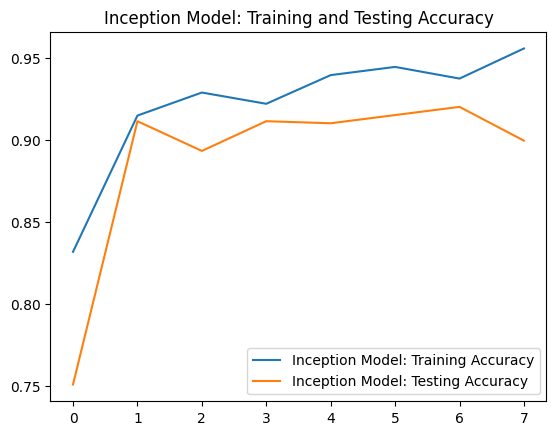

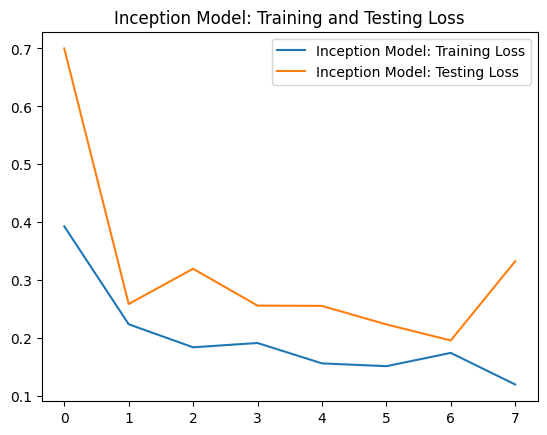

In [127]:
accuracy=inception_history.history['acc']
test_accuracy=inception_history.history['val_acc']

#getting the loss for each training epoch 
loss_inception=inception_history.history['loss']
loss_test_inception=inception_history.history['val_loss']

#number of training iterations 
num_epochs=range(len(accuracy))

#plotting testing and training accuracy per epoch 
plt.plot(num_epochs, accuracy, label='Inception Model: Training Accuracy')
plt.plot(num_epochs, test_accuracy, label='Inception Model: Testing Accuracy')
plt.title('Inception Model: Training and Testing Accuracy')
plt.legend()

#plotting testing and training loss per epoch 
plt.figure()
plt.plot(num_epochs, loss_inception, label='Inception Model: Training Loss')
plt.plot(num_epochs, loss_test_inception, label='Inception Model: Testing Loss')
plt.title('Inception Model: Training and Testing Loss')
plt.legend()

#### Results

In [128]:
test_prediction_inception=inception_model.predict(test_visual)

79/79 [==============================] - 18s 221ms/step


In [129]:
dir_test_indices=test_visual.index_array
test_correct_labels = [0 if n < 1112 else 1 for n in dir_test_indices]
# getting predictions in the form of probablities 
test_predictions_prob_inception= inception_model.predict(test_visual)

# converting the probablities into binary values 
test_prediction_labels_inception = [1 if n >= 0.5 else 0 for n in test_predictions_prob_inception]

print("Inception Waste Model Predictions: "+str(test_prediction_labels_inception))
print("Inception Correct Labels:"+str(test_correct_labels))

# determining the filepaths of misclassified waste
misclasssified_num_inception = 0
misclassified_filepaths_inception = []
correct_inception = []
for predicted_label, correct_label, dir_index in zip(test_prediction_labels_inception, test_correct_labels, test_visual.index_array):
  misclassified_filepaths_inception.append(test_visual.filepaths[dir_index])
  if predicted_label != correct_label:
    correct.append('incorrect')
    misclasssified_num_inception+= 1
  else:
    correct_inception.append('correct')

print("# of Total Images: "+str(len(correct_inception)))
print("# of Misclassified Images: "+str(misclasssified_num_inception))
     

79/79 [==============================] - 16s 205ms/step
Inception Waste Model Predictions: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,

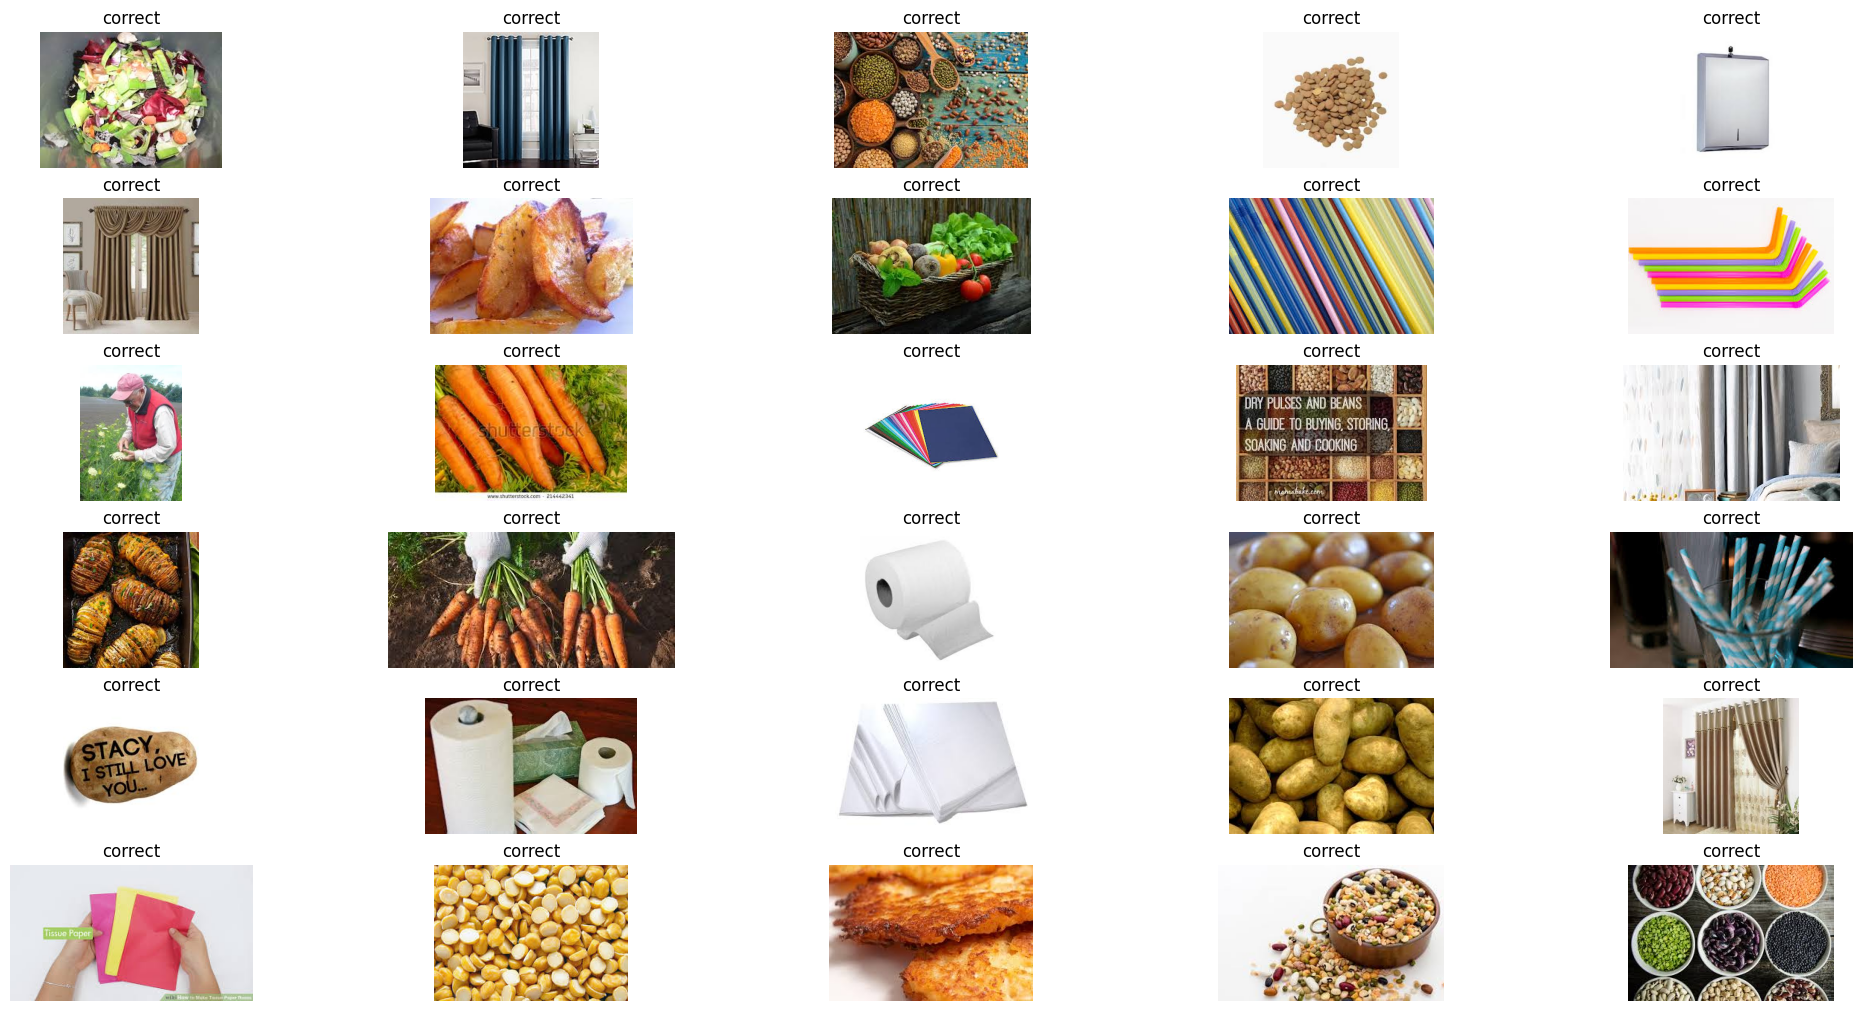

In [130]:
misclassified_images_inception = []
for filepath in misclassified_filepaths_inception:
  misclassified_images_inception.append(mpimg.imread(filepath))

#plotting the first 30 images 
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  
count = 0
for x in range(6):
  for y in range(5):
    axarr[x,y].imshow(misclassified_images_inception[count])
    if correct_inception[count] == 'correct':
      axarr[x,y].set_title(correct_inception[count])
    else:
      axarr[x,y].set_title(correct_inception[count], color='red')
    axarr[x,y].set_axis_off()
    count += 1 
plt.show()

In [131]:
# confusion matrix
matrix = confusion_matrix(test_correct_labels, test_prediction_labels_inception, labels=[0, 1])
print('Inception Confusion Matrix: \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(test_correct_labels, test_prediction_labels_inception, labels=[1,0]).reshape(-1)
print('Inception Outcome Values: \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(test_correct_labels, test_prediction_labels_inception, labels=[1,0])
print('Inception Classification Report (precision, recall, f1-score, and accuracy: \n',matrix)

Inception Confusion Matrix: 
 [[1105    7]
 [ 529  872]] 

Inception Outcome Values: 
 872 529 7 1105 

Inception Classification Report (precision, recall, f1-score, and accuracy: 
               precision    recall  f1-score   support

           1       0.99      0.62      0.76      1401
           0       0.68      0.99      0.80      1112

    accuracy                           0.79      2513
   macro avg       0.83      0.81      0.78      2513
weighted avg       0.85      0.79      0.78      2513



### ResNet Model 

In [132]:
# Download the pre-trained weights from URLs 
#defining the local file path where the downloaded weights will be saved 
url = "https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_filename = "/tmp/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

#requests.get method downloaded the pre-trained weights 
#verify.false skip SLL verification 
#we save the downloaded content to the local file in local_filename
downloaded_response = requests.get(url, verify=False)
with open(local_filename, "wb") as f:
    f.write(downloaded_response.content)

print("Download completed.")

# Load the pre-trained model
#InceptionV3: a pre-trained deep learning model from TensorFlow's Keras Module
#creating an instance of the Inception model
input_shape=(150, 150, 3)
pretrained_weights=local_filename

input_tensor=Input(shape=input_shape)
pre_resnet_trained_model = ResNet50(input_tensor=input_tensor, include_top=False, weights=None)
pre_resnet_trained_model.load_weights(pretrained_weights)  

# Freeze layers in the pre-trained model 
for layer in pre_resnet_trained_model.layers:
    layer.trainable = False

# Get the last layer's output
last_layer = pre_resnet_trained_model.get_layer('conv5_block3_out')
print('Last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Download completed.
Last layer output shape: (None, 5, 5, 2048)


In [133]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_incep_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'conv5_block3_out':
    unfreeze = True

# Configure the model
resnet_model = Model(pre_resnet_trained_model.input, x)

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
resnet_model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

#### Model Summary 

In [134]:
resnet_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

#### Training the Model

In [135]:
resnet_history = resnet_model.fit_generator(
      generator_train,
      steps_per_epoch=100,
      epochs=8,
      validation_data=generator_test,
      validation_steps=50,
      verbose=2)

Epoch 1/8


/var/folders/cn/j2pqcpd50hz3kxc263jytf240000gn/T/ipykernel_23353/2670290918.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_history = resnet_model.fit_generator(


100/100 - 88s - loss: 1.0003 - acc: 0.5487 - val_loss: 0.6851 - val_acc: 0.5619 - 88s/epoch - 877ms/step
Epoch 2/8
100/100 - 88s - loss: 0.6826 - acc: 0.5756 - val_loss: 0.6870 - val_acc: 0.5619 - 88s/epoch - 878ms/step
Epoch 3/8
100/100 - 84s - loss: 0.6933 - acc: 0.5435 - val_loss: 0.6886 - val_acc: 0.5494 - 84s/epoch - 837ms/step
Epoch 4/8
100/100 - 82s - loss: 0.6935 - acc: 0.5359 - val_loss: 0.6876 - val_acc: 0.5569 - 82s/epoch - 823ms/step
Epoch 5/8
100/100 - 83s - loss: 0.6865 - acc: 0.5616 - val_loss: 0.6886 - val_acc: 0.5487 - 83s/epoch - 826ms/step
Epoch 6/8
100/100 - 82s - loss: 0.6902 - acc: 0.5372 - val_loss: 0.6874 - val_acc: 0.5550 - 82s/epoch - 822ms/step
Epoch 7/8
100/100 - 86s - loss: 0.6897 - acc: 0.5451 - val_loss: 0.6880 - val_acc: 0.5519 - 86s/epoch - 863ms/step
Epoch 8/8
100/100 - 86s - loss: 0.6868 - acc: 0.5572 - val_loss: 0.6881 - val_acc: 0.5525 - 86s/epoch - 857ms/step


#### Training and Testing Accuracy/Loss Visualization

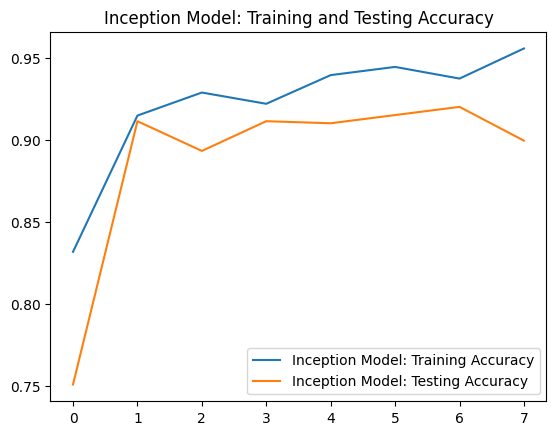

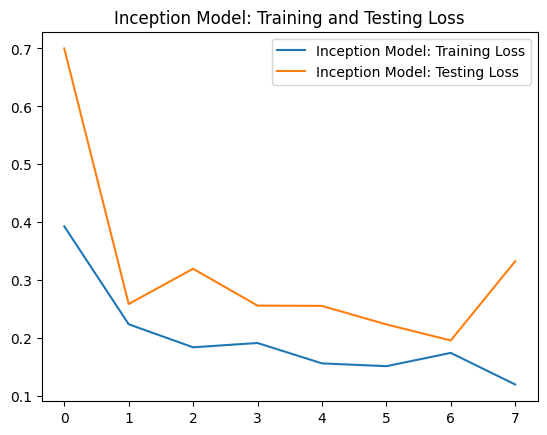

In [141]:
accuracy=inception_history.history['acc']
test_accuracy=inception_history.history['val_acc']

#getting the loss for each training epoch 
loss_inception=inception_history.history['loss']
loss_test_inception=inception_history.history['val_loss']

#number of training iterations 
num_epochs=range(len(accuracy))

#plotting testing and training accuracy per epoch 
plt.plot(num_epochs, accuracy, label='Inception Model: Training Accuracy')
plt.plot(num_epochs, test_accuracy, label='Inception Model: Testing Accuracy')
plt.title('Inception Model: Training and Testing Accuracy')
plt.legend()

#plotting testing and training loss per epoch 
plt.figure()
plt.plot(num_epochs, loss_inception, label='Inception Model: Training Loss')
plt.plot(num_epochs, loss_test_inception, label='Inception Model: Testing Loss')
plt.title('Inception Model: Training and Testing Loss')
plt.legend()

#### Results 

In [137]:
test_prediction_inception=resnet_model.predict(test_visual)

79/79 [==============================] - 40s 507ms/step


In [138]:
dir_test_indices=test_visual.index_array
test_correct_labels = [0 if n < 1112 else 1 for n in dir_test_indices]
# getting predictions in the form of probablities 
test_predictions_prob_resnet= resnet_model.predict(test_visual)

# converting the probablities into binary values 
test_prediction_labels_resnet = [1 if n >= 0.5 else 0 for n in test_predictions_prob_resnet]

print("Resnet Waste Model Predictions: "+str(test_prediction_labels_resnet))
print("Resnet Wste Model Correct Labels:"+str(test_correct_labels))

# determining the filepaths of misclassified waste
misclasssified_num_resnet = 0
misclassified_filepaths_resnet = []
correct_resnet = []
for predicted_label, correct_label, dir_index in zip(test_prediction_labels_resnet, test_correct_labels, test_visual.index_array):
  misclassified_filepaths_resnet.append(test_visual.filepaths[dir_index])
  if predicted_label != correct_label:
    correct.append('incorrect')
    misclasssified_num_resnet+= 1
  else:
    correct_resnet.append('correct')

print("# of Total Images: "+str(len(correct_inception)))
print("# of Misclassified Images with Resnet Model: "+str(misclasssified_num_resnet))

79/79 [==============================] - 40s 507ms/step
Resnet Waste Model Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

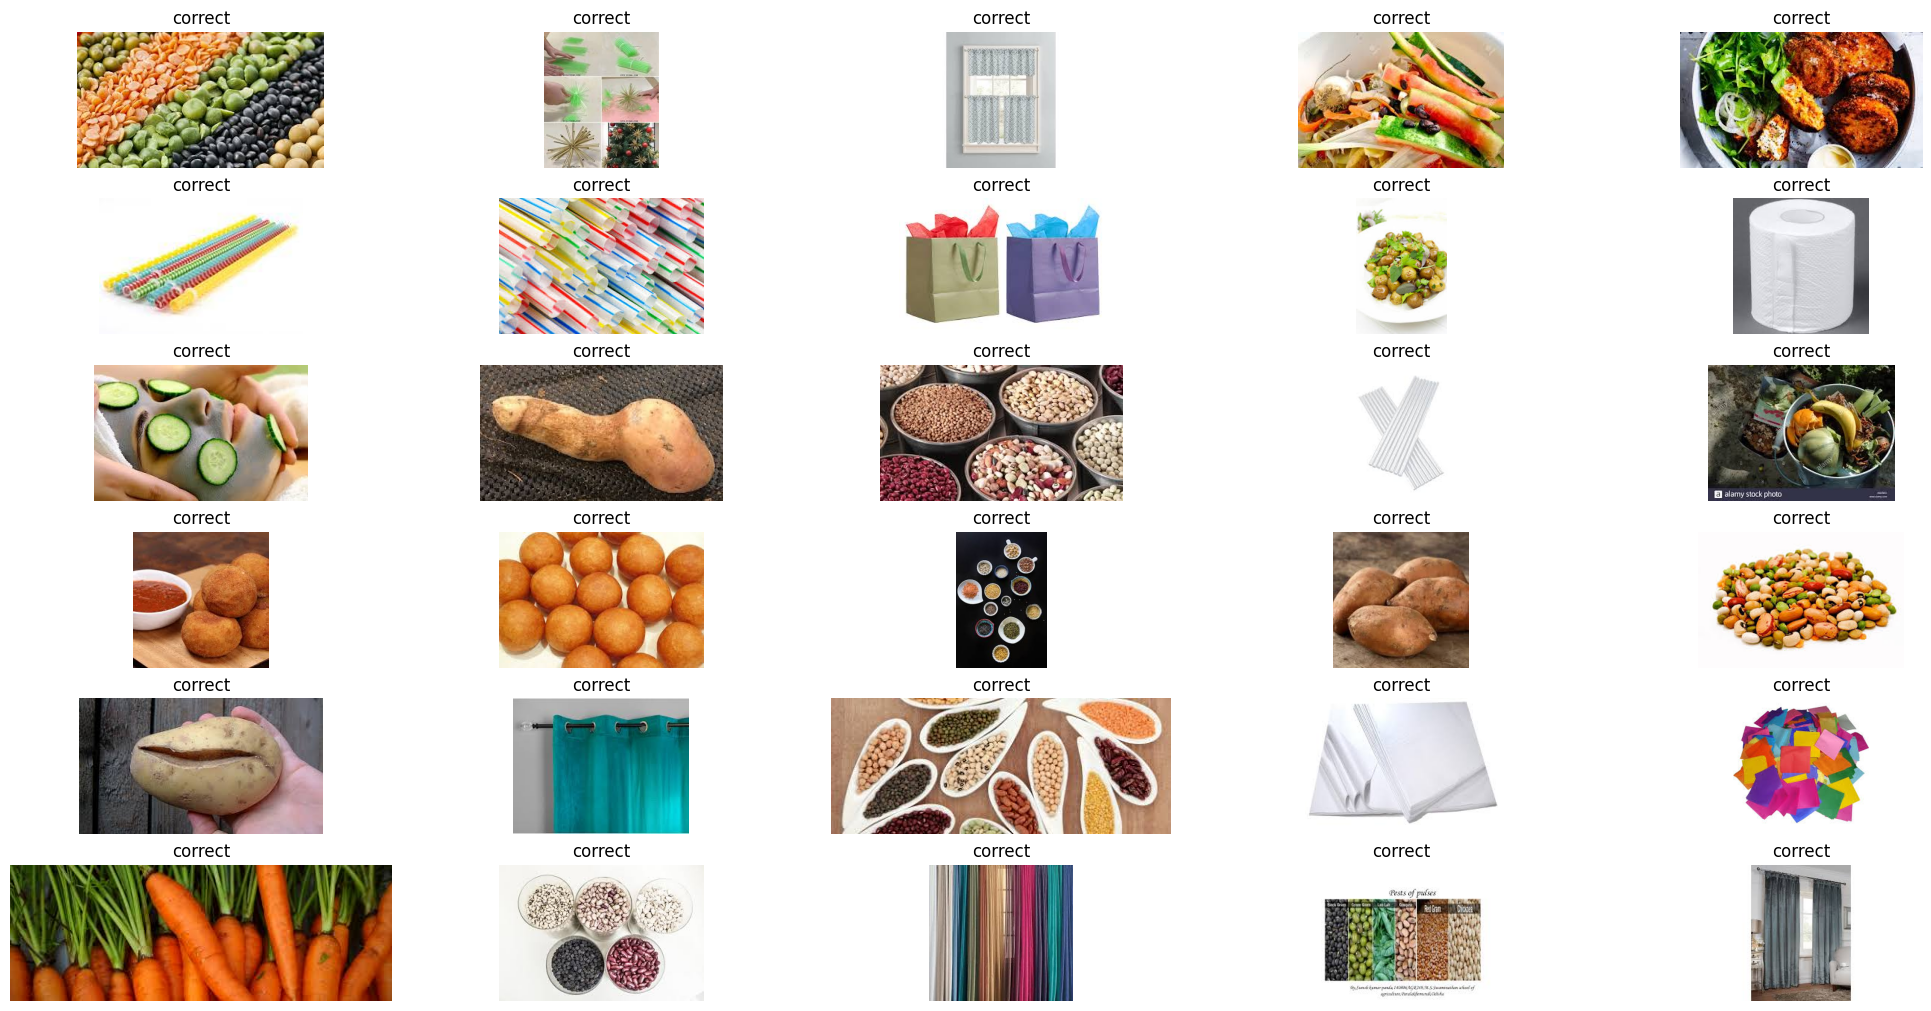

In [139]:
misclassified_images_resnet = []
for filepath in misclassified_filepaths_resnet:
  misclassified_images_resnet.append(mpimg.imread(filepath))

#plotting the first 30 images 
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  
count_resnet= 0
for x in range(6):
  for y in range(5):
    axarr[x,y].imshow(misclassified_images_resnet[count_resnet])
    if correct_resnet[count_resnet] == 'correct':
      axarr[x,y].set_title(correct_resnet[count_resnet])
    else:
      axarr[x,y].set_title(correct_resnet[count_resnet], color='red')
    axarr[x,y].set_axis_off()
    count_resnet += 1 
plt.show()

In [140]:
# confusion matrix
matrix = confusion_matrix(test_correct_labels, test_prediction_labels_resnet, labels=[0, 1])
print('Resnet Confusion Matrix: \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(test_correct_labels, test_prediction_labels_resnet, labels=[1,0]).reshape(-1)
print('Resnet Outcome Values: \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(test_correct_labels, test_prediction_labels_resnet, labels=[1,0])
print('Resnet Classification Report (precision, recall, f1-score, and accuracy: \n',matrix)

Resnet Confusion Matrix: 
 [[1112    0]
 [1401    0]] 

Resnet Outcome Values: 
 0 1401 0 1112 

Resnet Classification Report (precision, recall, f1-score, and accuracy: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      1401
           0       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.22      0.50      0.31      2513
weighted avg       0.20      0.44      0.27      2513



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.